In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
import pandas as pd
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder

In [14]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [10]:
!pip install mtcnn opencv-python --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00


In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# --- Add these imports for MTCNN ---

from mtcnn import MTCNN
import cv2

# Configuration
ROOT_DATASET_DIR = '/kaggle/input/s-2025-multi-class-pretraied-network-project/Data/Train'
OUTPUT_NPY_IMAGES = 'faces_cropped.npy'  # new name
OUTPUT_NPY_LABELS = 'labels_cropped.npy'
IMG_SIZE = (224, 224)  # For EfficientNet

# 1. Discover class folders and map to integer labels
class_dirs = sorted(
    d for d in os.listdir(ROOT_DATASET_DIR)
    if os.path.isdir(os.path.join(ROOT_DATASET_DIR, d))
)
label_map = {}
for d in class_dirs:
    try:
        lbl = int(d)           # folder '0'->0, '14'->14, '-1'->-1
    except ValueError:
        raise ValueError(f"Folder name '{d}' is not an integer label!")
    label_map[d] = lbl

# 2. Gather image paths and labels
image_paths = []
labels = []
for folder_name in class_dirs:
    lbl = label_map[folder_name]
    folder_path = os.path.join(ROOT_DATASET_DIR, folder_name)
    for fn in os.listdir(folder_path):
        if fn.lower().endswith(('.png', '.jpg', 'jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(folder_path, fn))
            labels.append(lbl)

num_images = len(image_paths)
print(f"Found {num_images} images.")
images_array = np.zeros((num_images, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
labels_array = np.array(labels, dtype=np.int32)

# --- Add: Setup MTCNN detector ---
from ultralytics import YOLO
import cv2

yolo_model = YOLO('yolov8n.pt')  # Use face-trained model if possible

def crop_face_yolo(img, model, img_size=(224,224)):
    results = model.predict(source=img, imgsz=img_size, conf=0.25, verbose=False)
    boxes = results[0].boxes
    if boxes.shape[0] == 0:
        h, w = img.shape[:2]
        min_dim = min(h, w)
        sx = (w - min_dim) // 2
        sy = (h - min_dim) // 2
        crop = img[sy:sy+min_dim, sx:sx+min_dim]
    else:
        largest = boxes.xyxy[boxes.conf.argmax()].cpu().numpy().astype(int)
        x1, y1, x2, y2 = largest
        crop = img[y1:y2, x1:x2]
    return cv2.resize(crop, img_size, interpolation=cv2.INTER_LINEAR)

fail_count = 0
for i, img_path in enumerate(tqdm(image_paths, desc='Cropping faces')):
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        face = crop_face_yolo(img, yolo_model, IMG_SIZE)
        images_array[i] = face
    except Exception as e:
        print(f"[!] Skipped {img_path}: {e}")
        fail_count += 1


# 5. Save as .npy files
np.save(OUTPUT_NPY_IMAGES, images_array)
np.save(OUTPUT_NPY_LABELS, labels_array)
print(f"✅ Saved {OUTPUT_NPY_IMAGES} and {OUTPUT_NPY_LABELS}")
print(f"[Info] Fallback to center crop for {fail_count} images.")


2025-07-11 12:41:01.218018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752237661.240758     123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752237661.247829     123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 4587 images.


Cropping faces: 100%|██████████| 4587/4587 [01:40<00:00, 45.63it/s]


✅ Saved faces_cropped.npy and labels_cropped.npy
[Info] Fallback to center crop for 0 images.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- 1) CONFIGURATION ------------------------------------------------------
IMAGES_PATH   = '/kaggle/working/faces_cropped.npy'
LABELS_PATH   = '/kaggle/working/labels_cropped.npy'
NUM_CLASSES   = 16
BATCH_SIZE    = 32
IMAGE_SIZE    = (224, 224)
EPOCHS_PHASE1 = 100
EPOCHS_PHASE2 = 50
MIXUP_ALPHA   = 0.4  # MixUp hyperparameter

# --- 2) MIXUP UTILITIES -----------------------------------------------------
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- 3) AUGMENTATION PIPELINE ------------------------------------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    A.CoarseDropout(num_holes_range=(1,2), hole_height_range=(0.1,0.2),
                    hole_width_range=(0.1,0.2), fill=0, p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

# --- 4) DATASET --------------------------------------------------------------
class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        labels = np.where(labels == -1, NUM_CLASSES-1, labels)
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Already (224, 224, 3) RGB
        if self.transform:
            img = self.transform(image=img)["image"]
        lbl = self.labels[idx]
        return img, lbl


# --- 5) MODEL SETUP ---------------------------------------------------------
def create_model():
    model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
    in_f = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_f, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    return model

# --- 6) TRAIN / VALID LOOP WITH MIXUP + SAMPLER -----------------------------
def train_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = create_model().to(device)
    print("Device being used:", device)
    print("Is model on CUDA?", next(model.parameters()).is_cuda)

    images = np.load(IMAGES_PATH)
    labels = np.load(LABELS_PATH)
    labels = np.where(labels == -1, NUM_CLASSES-1, labels)

    dataset = NumpyDataset(images, labels, transform=train_transform)
    print("Dataset size:", len(dataset))

    # Compute per-sample weights to balance classes
    class_sample_count = np.bincount(labels, minlength=NUM_CLASSES)
    # Inverse frequency
    class_weights = 1.0 / class_sample_count
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Split into train / val
    n_train = int(0.8 * len(dataset))
    n_val   = len(dataset) - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    print("Train size:", len(train_ds))
    print("Val size:", len(val_ds))

    # DataLoaders: use our sampler for train
    # Remove sampler; just shuffle for train!
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = create_model().to(device)
    crit   = nn.CrossEntropyLoss()
    opt    = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Phase 1: head only
    for p in model.parameters(): p.requires_grad = False
    for p in model.classifier.parameters(): p.requires_grad = True

    for epoch in range(EPOCHS_PHASE1):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            # apply mixup
            x_m, y_a, y_b, lam = mixup_data(x, y, MIXUP_ALPHA)

            opt.zero_grad()
            preds = model(x_m)
            loss  = mixup_criterion(crit, preds, y_a, y_b, lam)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
        print(f"[Head] Epoch {epoch+1}/{EPOCHS_PHASE1} train loss: {running_loss/len(train_loader.dataset):.4f}")

        # val eval
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1)==y).sum().item()
                total   += y.size(0)
        print(f"         Val Acc: {100*correct/total:.2f}%")

    # Phase 2: fine-tune last blocks + head
    for p in model.parameters(): p.requires_grad = False
    for blk in model.features[-5:]:
        for p in blk.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True

    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=1e-4, weight_decay=1e-5)

    for epoch in range(EPOCHS_PHASE2):
        model.train()
        running_loss = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            x_m, y_a, y_b, lam = mixup_data(x, y, MIXUP_ALPHA)

            opt.zero_grad()
            preds = model(x_m)
            loss  = mixup_criterion(crit, preds, y_a, y_b, lam)
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
        print(f"[Fine] Epoch {epoch+1}/{EPOCHS_PHASE2} train loss: {running_loss/len(train_loader.dataset):.4f}")

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1)==y).sum().item()
                total   += y.size(0)
        print(f"         Val Acc: {100*correct/total:.2f}%")

    return model

In [3]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    A.CoarseDropout(num_holes_range=(1, 2), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), fill=0, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 

# Run
if __name__ == "__main__":
    print("Starting training...")
    model = train_model()
    torch.save(model.state_dict(), "celebrity_classifier.pth")

In [4]:
# Run
if __name__ == "__main__":
    print("Starting training...")
    model = train_model()
    torch.save(model.state_dict(), "celebrity_classifier.pth")

Starting training...
Device being used: cuda
Is model on CUDA? True
Dataset size: 4587
Train size: 3669
Val size: 918
[Head] Epoch 1/100 train loss: 2.1966
         Val Acc: 41.94%
[Head] Epoch 2/100 train loss: 1.9941
         Val Acc: 43.36%
[Head] Epoch 3/100 train loss: 1.9325
         Val Acc: 45.32%
[Head] Epoch 4/100 train loss: 1.8979
         Val Acc: 46.08%
[Head] Epoch 5/100 train loss: 1.9023
         Val Acc: 48.47%
[Head] Epoch 6/100 train loss: 1.8377
         Val Acc: 48.15%
[Head] Epoch 7/100 train loss: 1.8731
         Val Acc: 47.17%
[Head] Epoch 8/100 train loss: 1.8128
         Val Acc: 50.98%
[Head] Epoch 9/100 train loss: 1.8713
         Val Acc: 49.78%
[Head] Epoch 10/100 train loss: 1.8287
         Val Acc: 53.49%
[Head] Epoch 11/100 train loss: 1.8512
         Val Acc: 51.31%
[Head] Epoch 12/100 train loss: 1.8006
         Val Acc: 52.51%
[Head] Epoch 13/100 train loss: 1.8083
         Val Acc: 51.63%
[Head] Epoch 14/100 train loss: 1.8019
         Val Acc: 50

In [5]:
import torch
from sklearn.metrics import f1_score

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    top1_correct = 0
    top3_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # logits
            _, preds_top1 = outputs.topk(1, dim=1)
            _, preds_top3 = outputs.topk(3, dim=1)

            total += labels.size(0)

            # Top-1 accuracy
            top1_correct += (preds_top1.squeeze() == labels).sum().item()

            # Top-3 accuracy
            # Check if true label is in top 3 predictions
            top3_correct += sum([labels[i] in preds_top3[i] for i in range(labels.size(0))])

            # Save all preds and labels for F1
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    top1_acc = top1_correct / total
    top3_acc = top3_correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")
    print(f"Top-3 Accuracy: {top3_acc*100:.2f}%")
    print(f"Macro F1 Score: {f1:.4f}")

    return top1_acc, top3_acc, f1


In [6]:
import numpy as np
from torch.utils.data import random_split, DataLoader
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Config
IMAGES_PATH   = '/kaggle/working/faces_cropped.npy'
LABELS_PATH   = '/kaggle/working/labels_cropped.npy'
NUM_CLASSES = 16
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Preprocessing (same as used in training)
val_transform = A.Compose([
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

# Dataset class (should be same as used before)
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        labels = np.where(labels == -1, NUM_CLASSES - 1, labels)
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(image=img)['image']
        return img, lbl

# Load and prepare data
images = np.load(IMAGES_PATH)
labels = np.load(LABELS_PATH)
full_dataset = NumpyDataset(images, labels, transform=val_transform)

# Re-split dataset (make sure random_state is the same as training)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Create val_loader
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


In [7]:
from torch.utils.data import DataLoader
import torch

# 1) Re-create your val_loader exactly as in training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
top1_acc, top3_acc, f1 = evaluate_model(model, val_loader, device)

print(f"""
→ Final results on validation set:
   • Top-1 Acc: {top1_acc*100:.2f}%
   • Top-3 Acc: {top3_acc*100:.2f}%
   • Weighted F1: {f1:.4f}
""")


Top-1 Accuracy: 99.35%
Top-3 Accuracy: 100.00%
Macro F1 Score: 0.9935

→ Final results on validation set:
   • Top-1 Acc: 99.35%
   • Top-3 Acc: 100.00%
   • Weighted F1: 0.9935



In [8]:
import os
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
import cv2

# === Paths ===
TEST_DIR = '/kaggle/input/s-2025-multi-class-pretraied-network-project/Data/Pridect'
OUTPUT_NPY = 'test_images_cropped.npy'
OUTPUT_IDS = 'test_ids.npy'
IMG_SIZE = (224, 224)

# Collect test image paths and IDs
image_paths = sorted([
    os.path.join(TEST_DIR, fn)
    for fn in os.listdir(TEST_DIR)
    if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))
])
ids = [os.path.basename(p) for p in image_paths]
num_images = len(image_paths)

# Preallocate array
images_array = np.zeros((num_images, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)

# Load YOLOv8 face detection model (must be face-trained if you want best results)
yolo_model = YOLO('yolov8n.pt')

def crop_face_yolo(img, model, img_size=(224,224)):
    results = model.predict(source=img, imgsz=img_size, conf=0.25, verbose=False)
    boxes = results[0].boxes
    if boxes.shape[0] == 0:
        h, w = img.shape[:2]
        min_dim = min(h, w)
        sx = (w - min_dim) // 2
        sy = (h - min_dim) // 2
        crop = img[sy:sy+min_dim, sx:sx+min_dim]
    else:
        largest = boxes.xyxy[boxes.conf.argmax()].cpu().numpy().astype(int)
        x1, y1, x2, y2 = largest
        crop = img[y1:y2, x1:x2]
    return cv2.resize(crop, img_size, interpolation=cv2.INTER_LINEAR)

fail_count = 0
for i, img_path in enumerate(tqdm(image_paths, desc='Cropping faces')):
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        face = crop_face_yolo(img, yolo_model, IMG_SIZE)
        images_array[i] = face
    except Exception as e:
        print(f"[!] Skipped {img_path}: {e}")
        fail_count += 1

np.save(OUTPUT_NPY, images_array)
np.save(OUTPUT_IDS, np.array(ids))
print(f"✅ Saved {OUTPUT_NPY} and {OUTPUT_IDS}")
print(f"[Info] Fallback to center crop for {fail_count} images.")


Cropping faces: 100%|██████████| 425/425 [00:10<00:00, 39.04it/s]


✅ Saved test_images_cropped.npy and test_ids.npy
[Info] Fallback to center crop for 0 images.


In [9]:
# --- Submission with NPY Test Data ---
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

# === Use same classifier as training ===
MODEL_PATH = 'celebrity_classifier.pth'
NUM_CLASSES = 16
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_CSV = 'EMAN_project.csv'

# Update these paths if needed
TEST_NPY = '/kaggle/working/test_images_cropped.npy'
TEST_IDS = '/kaggle/working/test_ids.npy'

test_transform = A.Compose([
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

class NumpyTestDataset(Dataset):
    def __init__(self, images, ids, transform=None):
        self.images = images
        self.ids = ids
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(image=img)['image']
        return self.ids[idx], img

test_images = np.load(TEST_NPY)
test_ids = np.load(TEST_IDS)
ds = NumpyTestDataset(test_images, test_ids, transform=test_transform)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
in_f = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_f, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES)
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

all_ids, all_preds = [], []
with torch.no_grad():
    for batch in dl:
        img_ids, imgs = batch
        imgs = imgs.to(DEVICE)
        out = model(imgs)
        label_idxs = out.argmax(1).cpu().numpy()
        label_idxs = [(-1 if l==15 else int(l)) for l in label_idxs]
        all_ids.extend(img_ids)
        all_preds.extend(label_idxs)

df = pd.DataFrame({'Id': all_ids, 'Label': all_preds})
df.to_csv(OUTPUT_CSV, index=False)
print(f"Submission saved to {OUTPUT_CSV}")


Submission saved to EMAN_project.csv


In [10]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
def evaluate_model(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            out = model(x)
            probs = torch.softmax(out, dim=1)
            preds = out.argmax(dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # --- Metrics ---
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    top1 = np.mean(y_pred == y_true)
    top3 = top_k_accuracy_score(y_true, y_prob, k=3)
    print(f"Top-1 Accuracy: {top1*100:.2f}%")
    print(f"Top-3 Accuracy: {top3*100:.2f}%")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9762    0.9880        42
           1     1.0000    1.0000    1.0000        42
           2     1.0000    1.0000    1.0000        35
           3     1.0000    1.0000    1.0000        47
           4     1.0000    1.0000    1.0000        34
           5     1.0000    1.0000    1.0000        35
           6     1.0000    1.0000    1.0000        38
           7     1.0000    0.9667    0.9831        30
           8     1.0000    1.0000    1.0000        32
           9     0.9744    1.0000    0.9870        38
          10     0.9714    1.0000    0.9855        34
          11     1.0000    1.0000    1.0000        28
          12     1.0000    1.0000    1.0000        35
          13     1.0000    0.9762    0.9880        42
          14     1.0000    0.9667    0.9831        30
          15     0.9894    0.9947    0.9920       376

    accuracy                         0.9935       918
   

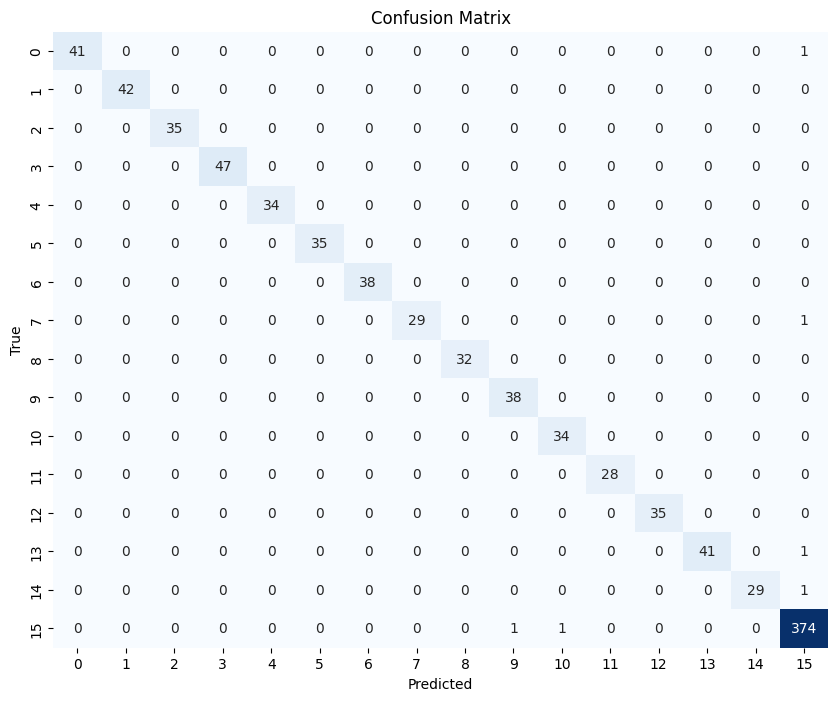

In [13]:
evaluate_model(model, val_loader)